# Data Preparation

The purpose of this notebook is to prepare data for machine learning models. It will use the data collected and it to fit the input and output of machine learning models. 

After running this notebook, the labels can be retrieved inside '/data' folder

In [40]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from data.helpers import *
import cv2
import random


## Data Augmention
To overcome the limitation of the AVFoundation framework, we collect our datasets in two formats. By combining HEIC and depth map grayscale into an RGBA image with depth-encoded alpha channel, we can extract more information about the colors, textures, and 3D geometry of objects in the scene, which can enhance the accuracy and robustness of the machine learning model for advanced classification tasks. Although thresholding techniques and contours mainly focus on the depth channel, in this research, we will also leverage the RGB channels to test the effectiveness of combining color and depth information in improving the performance of the model.

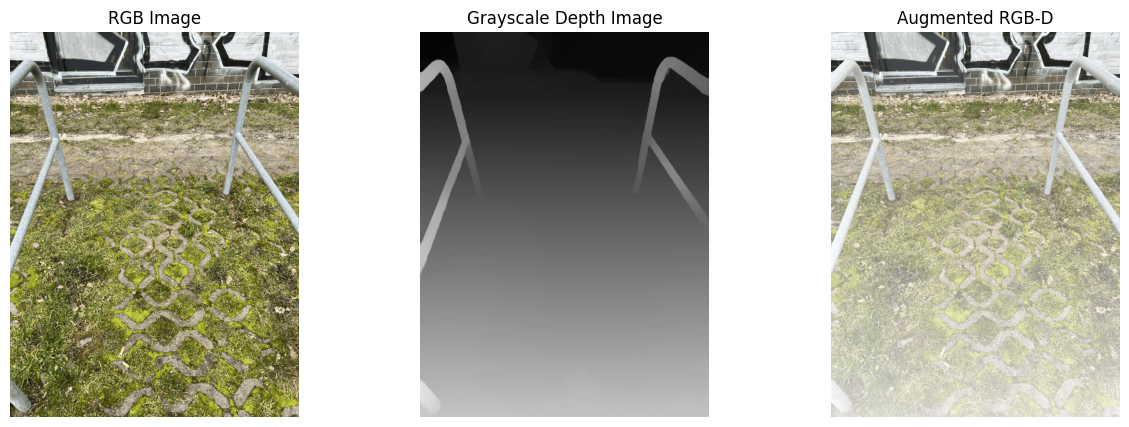

In [36]:
rgb_img = Image.open("data/test-png/side_obstacle1_rgb.png")
depth_img = Image.open("data/test-png/side_obstacle1_depth.png").convert("L")

depth_data = np.asarray(depth_img)
depth_data_norm = (depth_data - np.min(depth_data)) / (np.max(depth_data) - np.min(depth_data)) * 255
alpha_channel = Image.fromarray(255 - depth_data_norm.astype(np.uint8))
rgba_img = Image.merge("RGBA", tuple(rgb_img.split()[:3]) + (alpha_channel,))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(rgb_img)
ax[0].set_title('RGB Image')
ax[1].imshow(depth_img, cmap='gray')
ax[1].set_title('Grayscale Depth Image')
ax[2].imshow(rgba_img)
ax[2].set_title('Augmented RGB-D')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

## Image Sampling and Processing

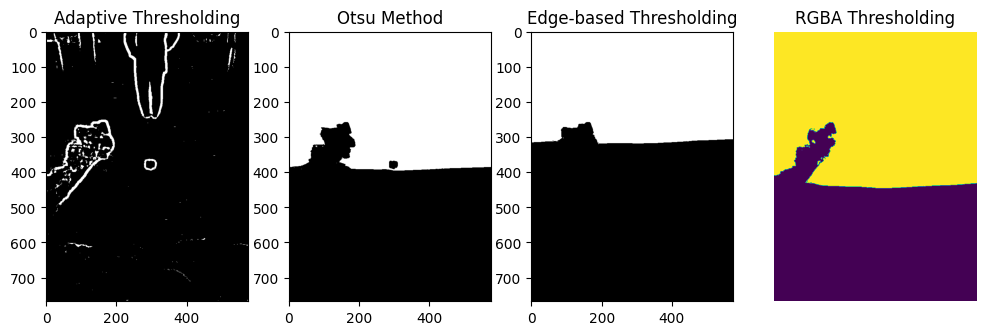

In [19]:
def convert_rgba_to_depth(rgba_img_path):
    rgba_img = Image.open(rgba_img_path)
    depth_data = 255 - np.asarray(rgba_img)[:,:,3]
    inverted_depth_data = 255 - depth_data
    return inverted_depth_data

def adaptive_thresholding(rgba_img_path, block_size=15, C=-1):
    depth_image = convert_rgba_to_depth(rgba_img_path)
    thresh = cv2.adaptiveThreshold(depth_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    return thresh

def otsu_method(rgba_img_path):
    depth_image = convert_rgba_to_depth(rgba_img_path)
    _, thresh = cv2.threshold(depth_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def edge_based_thresholding(rgba_img_path):
    depth_image = convert_rgba_to_depth(rgba_img_path)
    edges = cv2.Canny(depth_image, 100, 200)
    mean = np.mean(depth_image[edges != 0])
    _, thresh = cv2.threshold(depth_image, mean, 255, cv2.THRESH_BINARY)
    return thresh

def rgba_based_thresholding(rgba_img_path, threshold_value=127):
    img = cv2.imread(rgba_img_path, cv2.IMREAD_UNCHANGED)
    alpha_channel = img[:,:,3]
    thresholded_alpha = cv2.threshold(alpha_channel, threshold_value, 255, cv2.THRESH_BINARY)[1]
    return thresholded_alpha

image1 = adaptive_thresholding(rgba_img_path="data/test-png/ground_truth_rgbd.png", block_size=15, C=-1)
image2 = otsu_method(rgba_img_path="data/test-png/ground_truth_rgbd.png")
image3 = edge_based_thresholding(rgba_img_path="data/test-png/ground_truth_rgbd.png")
image4 = rgba_based_thresholding(rgba_img_path="data/test-png/ground_truth_rgbd.png")

fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].imshow(image1, cmap='gray')
ax[0].set_title('Adaptive Thresholding')
ax[1].imshow(image2, cmap='gray')
ax[1].set_title('Otsu Method')
ax[2].imshow(image3, cmap='gray')
ax[2].set_title('Edge-based Thresholding')
ax[3].imshow(image4)
ax[3].set_title('RGBA Thresholding')
plt.axis('off')
plt.axis('off')
plt.axis('off')
plt.axis('off')
plt.show()

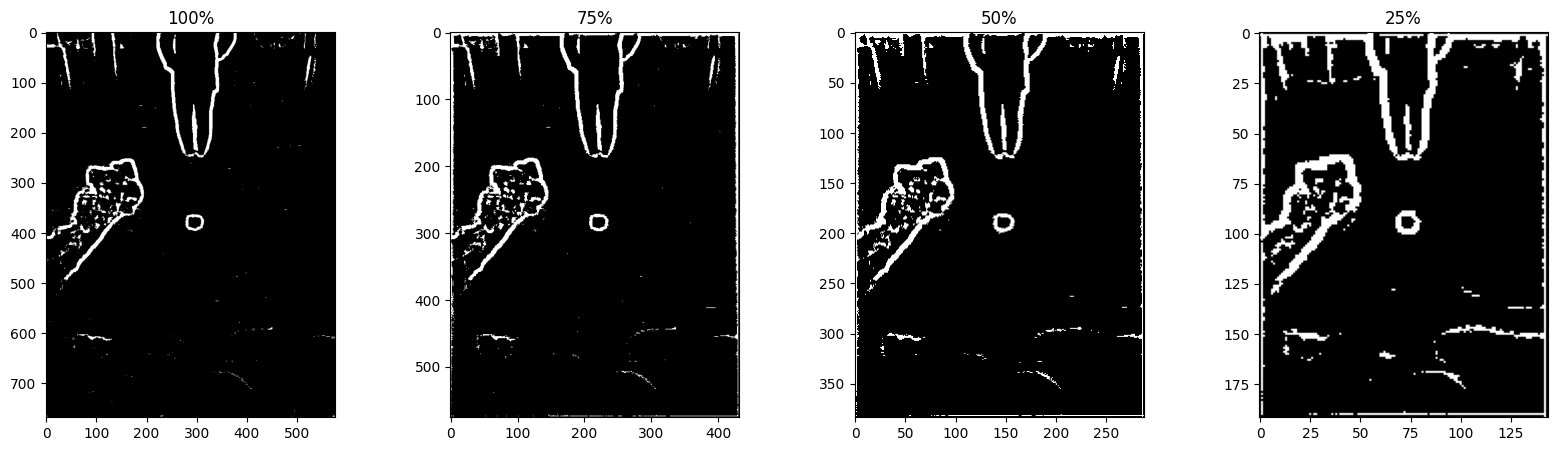

In [20]:

# Apply different thresholding techniques
image1 = adaptive_thresholding(rgba_img_path="data/test-png/ground_truth_rgbd.png", block_size=15, C=-1)
image2 = adaptive_thresholding(rgba_img_path="data/test-png/ground_truth_rgbd_75.png", block_size=13, C=-1)
image3 = adaptive_thresholding(rgba_img_path="data/test-png/ground_truth_rgbd_50.png", block_size=11, C=-1)
image4 = adaptive_thresholding(rgba_img_path="data/test-png/ground_truth_rgbd_25.png", block_size=9, C=-1)

# Plot results
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(image1, cmap='gray')
ax[0].set_title('100%')
ax[1].imshow(image2, cmap='gray')
ax[1].set_title('75%')
ax[2].imshow(image3, cmap='gray')
ax[2].set_title('50%')
ax[3].imshow(image4, cmap='gray')
ax[3].set_title('25%')
plt.show()

## Label Encoding

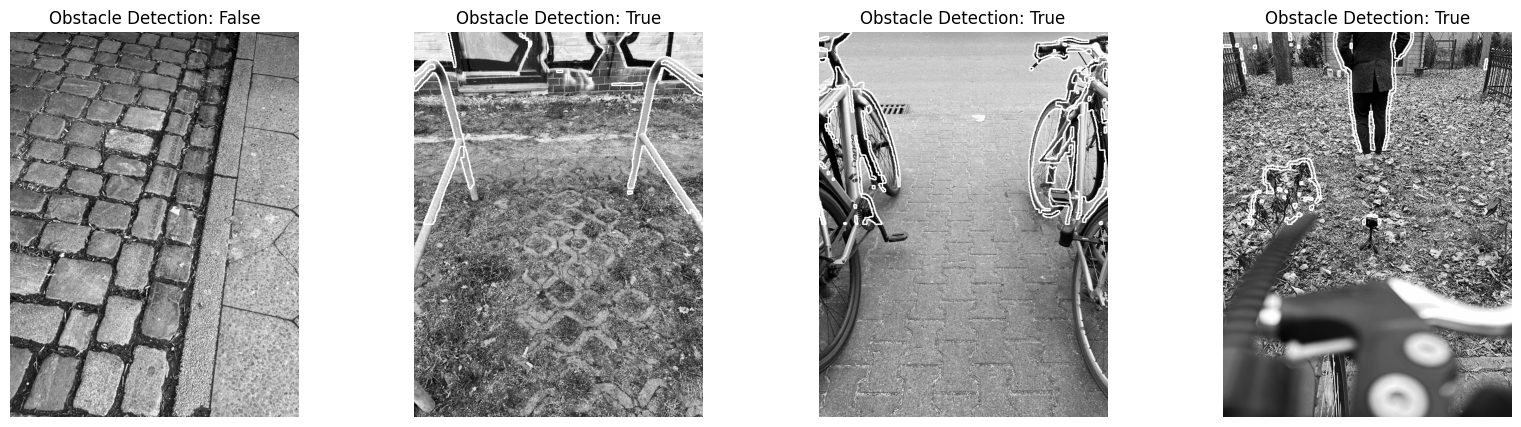

In [37]:
def detect_obstacle(rgba_img_path, obstacle_height_threshold=50):
    image = cv2.imread(rgba_img_path, cv2.IMREAD_GRAYSCALE)
    thresh = adaptive_thresholding(rgba_img_path=rgba_img_path, block_size=15, C=-1)
    roi = thresh[:image.shape[0]//2, :]

    # Apply morphological operations to remove noise and fill gaps
    kernel = np.ones((5, 5), np.uint8)
    roi = cv2.morphologyEx(roi, cv2.MORPH_OPEN, kernel)
    roi = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)

    # Find contours in ROI
    contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, (255, 255, 255), 2)

    # Loop over contours and check for obstacle
    obstacle_detected = False
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if h > obstacle_height_threshold:
            obstacle_detected = True
            break
    return image, obstacle_detected

# Apply different thresholding techniques
image1, result1  = detect_obstacle(rgba_img_path="data/test-png/no_obstacle_rgbd.png", obstacle_height_threshold=50)
image2, result2  = detect_obstacle(rgba_img_path="data/test-png/side_obstacle1_rgbd.png", obstacle_height_threshold=50)
image3, result3  = detect_obstacle(rgba_img_path="data/test-png/side_obstacle2_rgbd.png", obstacle_height_threshold=50)
image4, result4  = detect_obstacle(rgba_img_path="data/test-png/ground_truth_rgbd.png", obstacle_height_threshold=50)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(image1, cmap='gray')
ax[0].set_title(f"Obstacle Detection: {result1}")
ax[1].imshow(image2, cmap='gray')
ax[1].set_title(f"Obstacle Detection: {result2}")
ax[2].imshow(image3, cmap='gray')
ax[2].set_title(f"Obstacle Detection: {result3}")
ax[3].imshow(image4, cmap='gray')
ax[3].set_title(f"Obstacle Detection: {result4}")
for ax in ax.flat:
    ax.axis('off')
plt.show()

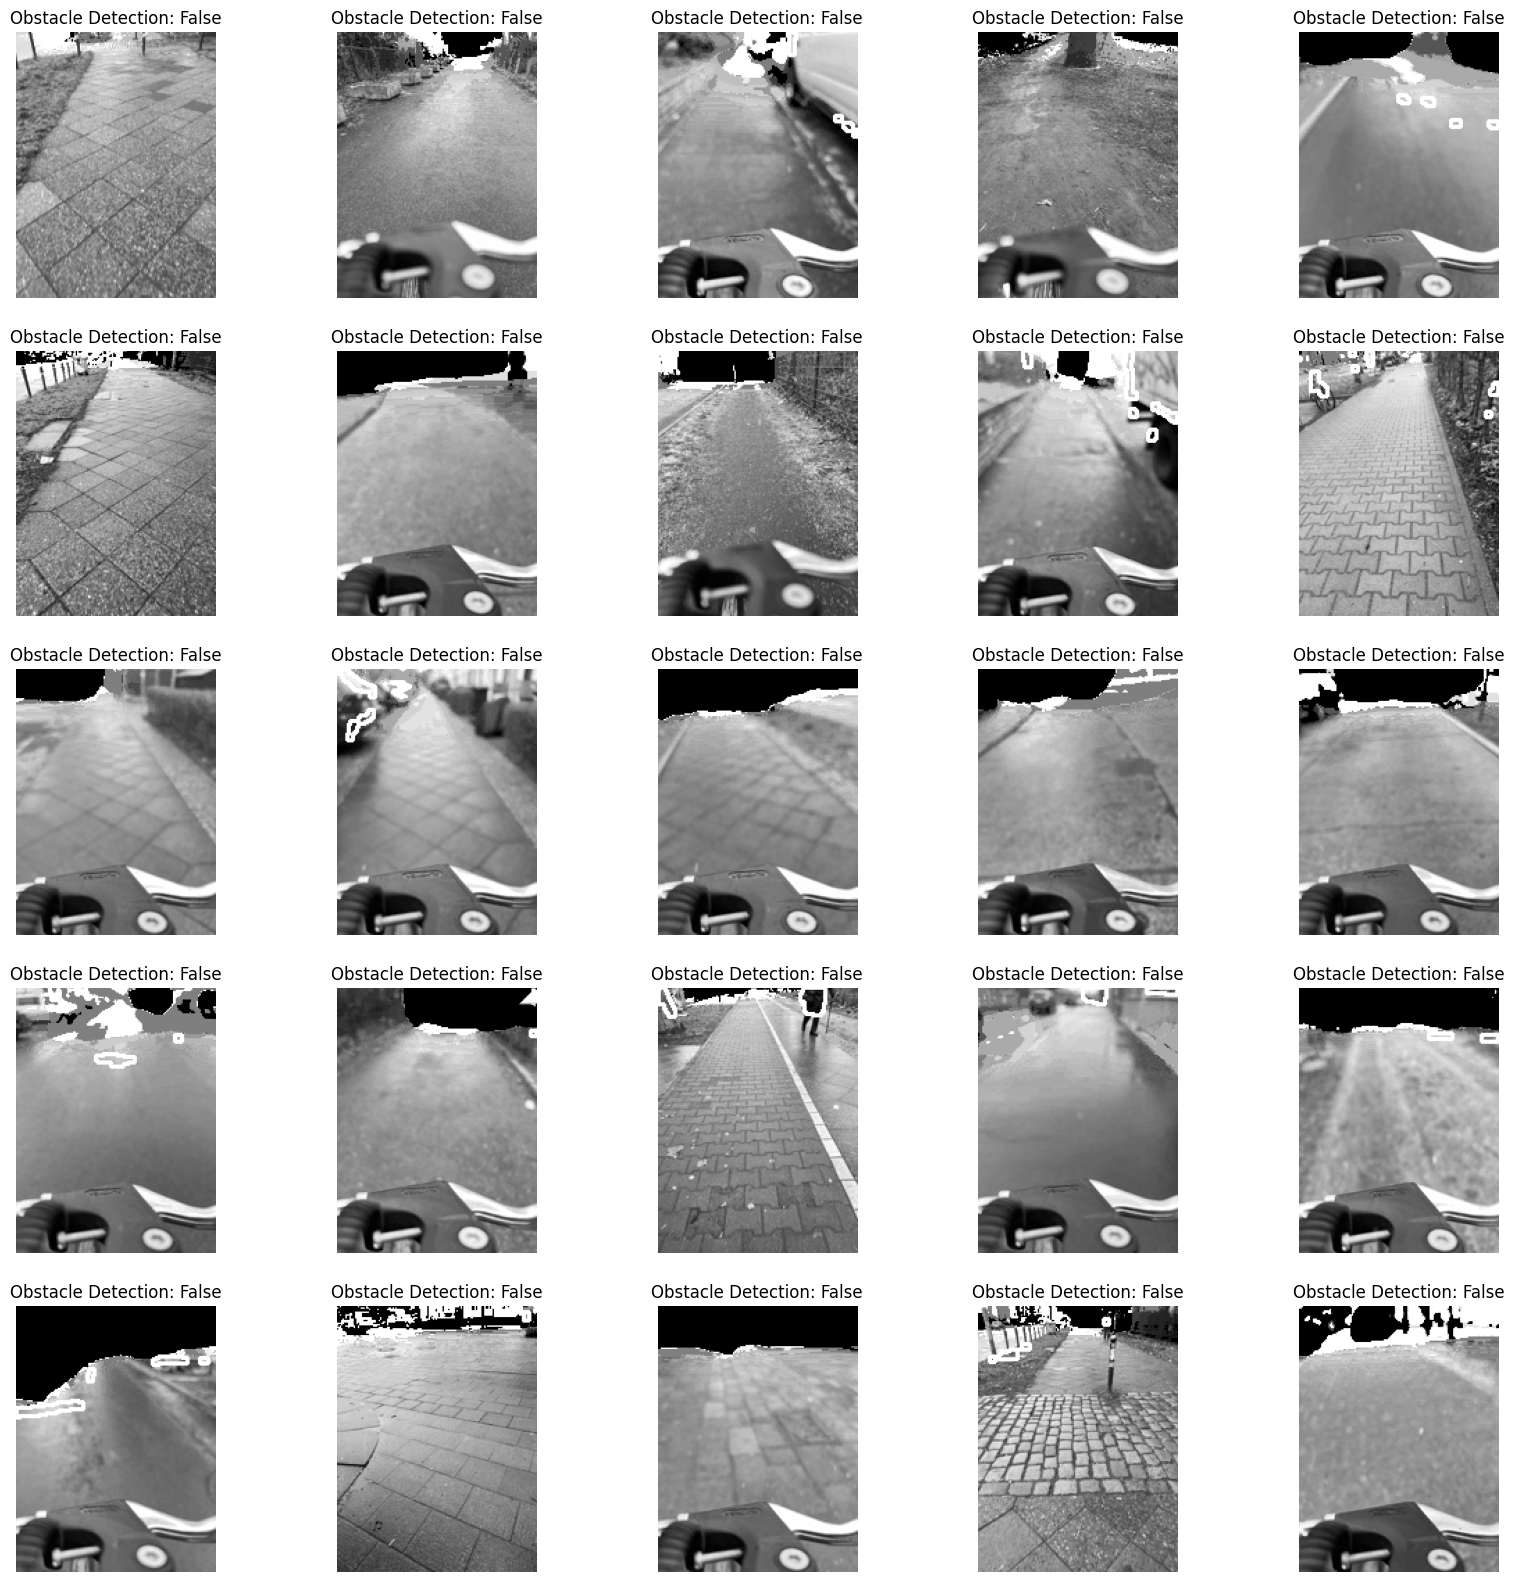

In [46]:
def detect_obstacles_using_random_selection(input_dir, obstacle_height_threshold=70):
    num_images = 25
    images = random.sample(os.listdir(input_dir), num_images)
    fig, ax = plt.subplots(5, 5, figsize=(20, 20))
    for i, img in enumerate(images):
        img_path = os.path.join(input_dir, img)
        image, obstacle_detected = detect_obstacle(img_path, obstacle_height_threshold)
        row = i // 5
        col = i % 5
        ax[row][col].imshow(image, cmap='gray')
        ax[row][col].set_title(os.path.splitext(img)[0])
        ax[row][col].axis('off')
        ax[row][col].set_title(f"Obstacle Detection: {obstacle_detected}")
    plt.show()

detect_obstacles_using_random_selection(
    input_dir="./data/train-rgbd/", obstacle_height_threshold=50)


In [52]:
def prepare_rgbd_to_npy(input_dir, output_file):
    data = []
    for file in os.listdir(input_dir):
        if file.endswith(".png"):
            file_path = os.path.join(input_dir, file)
            image = np.array(cv2.imread(file_path, cv2.IMREAD_UNCHANGED))
            data.append([file, image])

    np.save(output_file, np.array(data))

prepare_rgbd_to_npy(input_dir="data/train-rgbd", output_file="data/training_images.npy")

/var/folders/sl/g90lyn211sj69bdnk9qfl_gc0000gn/T/ipykernel_32416/3533039625.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(output_file, np.array(data))


In [53]:
def prepare_labels(input_dir, output_file):
    data = []
    for file in os.listdir(input_dir):
        if file.endswith(".png"):
            file_path = os.path.join(input_dir, file)
            image, result  = detect_obstacle(rgba_img_path=file_path, obstacle_height_threshold=70)
            data.append(result)

    np.save(output_file, np.array(data))

prepare_labels(input_dir="data/train-rgbd", output_file="data/training_labels.npy")

In [54]:
# Checking the length of the data
data_images = np.load('data/training_images.npy', allow_pickle=True)
data_labels = np.load('data/training_labels.npy', allow_pickle=True)

if len(data_images) == len(data_labels):
    print("Labels of data are equal")
else:
    print("Labels are test data are not equal")


Labels of data are equal
